In [3]:
from rag import RAG
from mlx_lm import load, generate
import deepl
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
AUTH_KEY = "TOKEN"
translator = deepl.Translator(AUTH_KEY)

In [5]:
model, tokenizer = load("mlx-community/quantized-gemma-7b-it")
rag_tasks = {0: {"result": "Test", "prompt": "", "start": 0}}
rag = RAG(translator, tokenizer, translator, rag_tasks)

data = rag.collection.get()
print(len(data["documents"]))

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/55.3k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.34G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs-us-1.hf.co/repos/ee/3f/ee3f4b3dcf494bf2166dda71a071302d2b07986251f1aae3a4504eaf057e4b86/0ec1248c4589233636c3c49423a9ec29fae3f66659b8b40f7fbc18069f8f0e47?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model-00001-of-00002.safetensors%3B+filename%3D%22model-00001-of-00002.safetensors%22%3B&Expires=1738145552&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczODE0NTU1Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2VlLzNmL2VlM2Y0YjNkY2Y0OTRiZjIxNjZkZGE3MWEwNzEzMDJkMmIwNzk4NjI1MWYxYWFlM2E0NTA0ZWFmMDU3ZTRiODYvMGVjMTI0OGM0NTg5MjMzNjM2YzNjNDk0MjNhOWVjMjlmYWUzZjY2NjU5YjhiNDBmN2ZiYzE4MDY5ZjhmMGU0Nz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=q-iLEgKG6Jq8PBE5E5rI6D8MypBwQE45JWLucABgHSK-rDrEUkB%7EXuI34P17tK895pdDnfDVZ2VpxBEgE2RhjVfJM75CKMvGIPbFRD9-yMcgIHjlkF4lKr5JiIrse3Ai2nJd8I-EXmza35VnyVuMaqOnNP-anj7vfAAiypuj7MAJGoaAPKqhqCrgPY1FpXJmbHeeBP33pqqvljPPyFeYlHuFM3b3KkgFaljP

model-00002-of-00002.safetensors:  34%|###3      | 199M/595M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   4%|3         | 199M/5.34G [00:00<?, ?B/s]

⚠️ It looks like you upgraded from a version below 0.6 and could benefit from vacuuming your database. Run chromadb utils vacuum --help for more information.


512


In [6]:
questions = []
for id, document in tqdm(zip(data["ids"], data["documents"])):
    prompt = f"<start_of_turn>user Create a specific question for this text in the same language as the text: {document} <start_of_turn>model Sure, here is the question:"
    question = generate(model, tokenizer, prompt=prompt, verbose=False, max_tokens=1000)
    question = question.replace("\n", "")
    question = question.replace("*", "")
    questions.append(question)

# Save questions
with open("questions.txt", "w") as f:
    for question in questions:
        f.write(question + "\n")

512it [17:48,  2.09s/it]


In [7]:
import random
random_questions = random.sample(questions, 5)
for question in random_questions:
    print(question)

What was the purpose of the Berlin Wall as described in this text?
What is the specific charge against Trump in the Fulton County case related to the 2020 presidential election in Georgia?
Did the passage describe the first time Trump's veto was overridden in his presidency?
Did Trump attempt to influence Comey to stop the investigations against Michael Flynn, as reported by the New York Times (NYT)?
Why was the first Ost German allowed to leave West-Berlin at 21:20 Uhr on Bornholmer Straße, and what was the issue with their Personalausweise?


In [6]:
accuracies = {}
lengths = [1, 2, 3, 4, 5]
for n_results in lengths:
    datapoints = []
    for id, question in zip(data["ids"], questions):
        results = rag.collection.query(query_texts=question, n_results=n_results)
        result_ids = results["ids"][0]
        if id in result_ids:
            datapoints.append(1)
        else:
            datapoints.append(0)

    accuracies[n_results] = sum(datapoints) / len(datapoints)

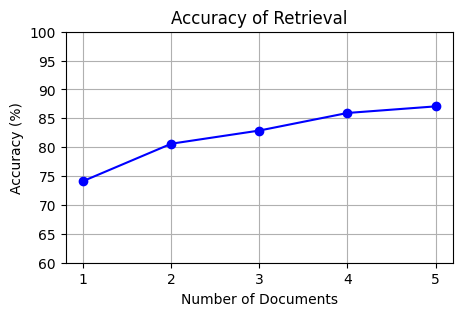

In [8]:
x = list(accuracies.keys())
y = [value * 100 for value in list(accuracies.values())]

plt.figure(figsize=(5, 3))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Retrieval')
plt.xlabel('Number of Documents')
plt.ylabel('Accuracy (%)')
plt.ylim(60, 100)  # Set y-axis limits to show percentages clearly
plt.grid(True)
plt.xticks(x)  # Ensure all x-axis values are shown
plt.show()